## import libraries

In [1]:
import pandas as pd
import seaborn as sns
import os
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import gc
import nltk
import lightgbm as lgb
from tqdm import tqdm
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')


def game_clock_to_numeric(df, name_of_input_col='gameClock', name_for_output_col='game_clock_seconds'):
    game_clock_split = df[name_of_input_col].str.split(':')

    for i in tqdm(range(len(game_clock_split)), total=len(game_clock_split)):
        n_mins_remaining = int(game_clock_split[i][0])

        n_secs_remaining = n_mins_remaining*60

        n_secs_remaining += int(game_clock_split[i][1])

        df.loc[i,name_for_output_col] = n_secs_remaining

    return df

def generate_series_id(df, key='gameId', series_sequencer='play_start_times', end_series_on='is_turnover'):
    
    df = df.sort_values([key, series_sequencer])
    series_id = 1
    for idx, row in df.iterrows():
                
        is_series_over = row.is_turnover
        
        df.loc[idx, 'series_id'] = series_id
        
        if is_series_over:
            series_id += 1
            
    return df

def is_series_successful(df):
    
    
    each_series = df.series_id.unique()

    for series in tqdm(each_series, total=each_series.shape[0]):

        visitors_scored = df.loc[df.series_id == series, 'visitors_scored']
        home_team_scored = df.loc[df.series_id == series, 'home_team_scored']
        
        if visitors_scored.sum()>0:
            df.loc[df.series_id == series, 'series_successful'] = 1
        else:
            df.loc[df.series_id == series, 'series_successful'] = 0
        
        if home_team_scored.sum()>0:
            df.loc[df.series_id == series, 'series_successful'] = 1
        else:
            df.loc[df.series_id == series, 'series_successful'] = 0
    
    return df   

def create_date_features(df, date_col='gameDate'):
    df[date_col] = pd.to_datetime(df[date_col])

    df[f'{date_col}_month'] = df[date_col].dt.month
    df[f'{date_col}_day'] = df[date_col].dt.dayofweek
    df[f'{date_col}_year'] = df[date_col].dt.year

    return df    



pd.options.display.max_columns=100
pd.options.display.max_rows=100


[nltk_data] Downloading package stopwords to /Users/ciannudi-
[nltk_data]     muldoon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## ingest data

In [2]:
data_files = os.listdir('data')
data_files.sort()
data_files

['.ipynb_checkpoints',
 'NFLBirthdays.csv',
 'RL_test_data.csv',
 'games.csv',
 'pffScoutingData.csv',
 'players.csv',
 'plays.csv',
 'processed',
 'raw',
 'train.csv',
 'week1.csv',
 'week2.csv',
 'week3.csv',
 'week4.csv',
 'week5.csv',
 'week6.csv',
 'week7.csv',
 'week8.csv']

In [3]:
games_df = pd.read_csv('./data/games.csv') # this file contains the schedule of games
scouting_data = pd.read_csv('./data/pffScoutingData.csv') # this file contains player roles relative to each play
players = pd.read_csv('./data/players.csv') # this file contains player descriptions
plays = pd.read_csv('./data/plays.csv') # this file tells us about each play in each game
nfl_birthdays = pd.read_csv('./data/NFLBirthdays.csv')
weeks_df = pd.read_csv('./data/week1.csv') # this file contains player tracking data

for file_name in data_files:
    
    if 'week' in file_name and file_name != 'week1.csv':
    
        d = pd.read_csv(f"./data/{file_name}", engine='python', error_bad_lines=False)

        weeks_df = pd.concat([d,weeks_df])



/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/1700909943.py:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  d = pd.read_csv(f"./data/{file_name}", engine='python', error_bad_lines=False)
/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/1700909943.py:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  d = pd.read_csv(f"./data/{file_name}", engine='python', error_bad_lines=False)
Skipping line 1093237: unexpected end of data
/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/1700909943.py:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  d = pd.read_csv(f"./data/{file_name}", engine='python', error_bad_lines=False)
Skipping line 908085: unexpected end of data
/va

## Including additional birthdays for those missing in NFL's dataset

In [4]:
print(players.shape[0])
print(nfl_birthdays.shape[0])

players.displayName = players.displayName.str.lower()
nfl_birthdays.player = nfl_birthdays.player.str.lower()

players.displayName = players.displayName.replace('[^a-z0-9 ]', '', regex=True)
nfl_birthdays.player = nfl_birthdays.player.replace('[^a-z0-9 ]', '', regex=True)

players = pd.merge(players, nfl_birthdays, left_on='displayName', right_on='player', how='outer')

players.isna().sum()

1679
514


nflId                194
height               194
weight               194
birthDate            426
collegeName          418
officialPosition     194
displayName          194
player              1356
position            1356
team                1356
birthday            1357
dtype: int64

In [5]:
players = players[players.nflId.notna()]
players.birthDate = pd.to_datetime(players.birthDate)
players.birthday = pd.to_datetime(players.birthday)

mask = ((players.birthDate.isna()) & (players.birthday.notna()))
players[mask]


,nflId,height,weight,birthDate,collegeName,officialPosition,displayName,player,position,team,birthday
1241,52430.0,6-3,192.0,NaT,Louisiana State,WR,justin jefferson,justin jefferson,WR,MIN,1999-06-16
1466,53180.0,6-0,220.0,NaT,NaN,RB,tyson williams,tyson williams,RB,FA,1996-09-04
1468,53430.0,6-6,220.0,NaT,NaN,QB,trevor lawrence,trevor lawrence,QB,JAC,1999-10-06
1469,53431.0,6-2,208.0,NaT,NaN,QB,zach wilson,zach wilson,QB,NYJ,1999-08-03
1470,53432.0,6-4,226.0,NaT,NaN,QB,trey lance,trey lance,QB,SF,2000-05-09
1471,53433.0,6-6,250.0,NaT,NaN,TE,kyle pitts,kyle pitts,TE,ATL,2000-10-06
1472,53434.0,6-1,200.0,NaT,NaN,WR,jamarr chase,jamarr chase,WR,CIN,2000-03-01
1473,53435.0,5-10,182.0,NaT,NaN,WR,jaylen waddle,jaylen waddle,WR,MIA,1998-11-25
1477,53439.0,6-1,165.0,NaT,NaN,WR,devonta smith,devonta smith,WR,PHI,1998-11-14
1478,53440.0,6-3,223.0,NaT,NaN,QB,justin fields,justin fields,QB,CHI,1999-03-05


In [6]:
players.loc[mask, 'birthDate'] = players.loc[mask, 'birthday'].values
players[mask]

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName,player,position,team,birthday
1241,52430.0,6-3,192.0,1999-06-16,Louisiana State,WR,justin jefferson,justin jefferson,WR,MIN,1999-06-16
1466,53180.0,6-0,220.0,1996-09-04,NaN,RB,tyson williams,tyson williams,RB,FA,1996-09-04
1468,53430.0,6-6,220.0,1999-10-06,NaN,QB,trevor lawrence,trevor lawrence,QB,JAC,1999-10-06
1469,53431.0,6-2,208.0,1999-08-03,NaN,QB,zach wilson,zach wilson,QB,NYJ,1999-08-03
1470,53432.0,6-4,226.0,2000-05-09,NaN,QB,trey lance,trey lance,QB,SF,2000-05-09
1471,53433.0,6-6,250.0,2000-10-06,NaN,TE,kyle pitts,kyle pitts,TE,ATL,2000-10-06
1472,53434.0,6-1,200.0,2000-03-01,NaN,WR,jamarr chase,jamarr chase,WR,CIN,2000-03-01
1473,53435.0,5-10,182.0,1998-11-25,NaN,WR,jaylen waddle,jaylen waddle,WR,MIA,1998-11-25
1477,53439.0,6-1,165.0,1998-11-14,NaN,WR,devonta smith,devonta smith,WR,PHI,1998-11-14
1478,53440.0,6-3,223.0,1999-03-05,NaN,QB,justin fields,justin fields,QB,CHI,1999-03-05


In [7]:
players = players.drop(nfl_birthdays.columns, axis=1)

# Plays feature engineering

In [8]:
print(f"Mean plays per game: {round(plays.groupby(['gameId'])['playId'].count().mean(),2)}")
print(f"Mean plays per quarter: {round(plays.groupby(['gameId','quarter'])['playId'].count().mean(),2)}")

Mean plays per game: 70.15
Mean plays per quarter: 17.12


In [9]:
key = ['gameId']

plays = plays.sort_index()

plays = plays.merge(
    plays.groupby(key)[['defensiveTeam', 'preSnapVisitorScore', 'possessionTeam', 'preSnapHomeScore']].shift(-1).fillna(-1)
    , left_index=True
    , right_index=True
    , suffixes=('', '_next_play')
)

plays[key + list(plays.loc[:,plays.columns.str.contains("defensiveTeam|preSnapVisitorScore|possessionTeam|preSnapHomeScore")].columns)]


,gameId,possessionTeam,defensiveTeam,preSnapHomeScore,preSnapVisitorScore,defensiveTeam_next_play,preSnapVisitorScore_next_play,possessionTeam_next_play,preSnapHomeScore_next_play
0,2021090900,TB,DAL,0,0,TB,0.0,DAL,0.0
1,2021090900,DAL,TB,0,0,TB,0.0,DAL,0.0
2,2021090900,DAL,TB,0,0,TB,0.0,DAL,0.0
3,2021090900,DAL,TB,0,0,TB,0.0,DAL,0.0
4,2021090900,DAL,TB,0,0,DAL,0.0,TB,0.0
...,...,...,...,...,...,...,...,...,...
8553,2021110100,KC,NYG,17,17,KC,17.0,NYG,20.0
8554,2021110100,NYG,KC,20,17,KC,17.0,NYG,20.0
8555,2021110100,NYG,KC,20,17,KC,17.0,NYG,20.0
8556,2021110100,NYG,KC,20,17,KC,17.0,NYG,20.0


## Determining when the ball has been turned over

In [10]:
conditions = [(plays.defensiveTeam != plays.defensiveTeam_next_play), (plays.defensiveTeam == plays.defensiveTeam_next_play)]
values = [1, 0]

plays['is_turnover'] = np.select(conditions, values)
plays['is_turnover'].value_counts()

0    6362
1    2196
Name: is_turnover, dtype: int64

## Determining when the turn over was due to a score from the visiting team

In [11]:
conditions = [(plays.preSnapVisitorScore_next_play != plays.preSnapVisitorScore) & plays.preSnapVisitorScore_next_play.notna(), (plays.preSnapVisitorScore_next_play == plays.preSnapVisitorScore)]
values = [1, 0]

plays['visitors_scored'] = np.select(conditions, values)
plays['visitors_scored'] = plays['visitors_scored'].astype('int8')
plays['visitors_scored'].value_counts()

0    7922
1     636
Name: visitors_scored, dtype: int64

## Determining when the turn over was due to a score from the home team

In [12]:
conditions = [(plays.preSnapHomeScore != plays.preSnapHomeScore_next_play) & plays.preSnapHomeScore_next_play.notna(), (plays.preSnapHomeScore == plays.preSnapHomeScore_next_play)]
values = [1, 0]
plays['home_team_scored'] = np.select(conditions, values)
plays['home_team_scored'] = plays['home_team_scored'].astype('int8')
plays['home_team_scored'].value_counts()


0    7920
1     638
Name: home_team_scored, dtype: int64

## Determining start time of each play

In [13]:
print(plays.shape[0])

weeks_df.time = pd.to_datetime(weeks_df.time)
weeks_df = weeks_df.sort_values(['gameId', 'playId', 'time'])


play_start_times = pd.Series(weeks_df.groupby(['gameId', 'playId'])['time'].first().dt.strftime("%H:%M:%S"), name='play_start_times')
plays = pd.merge(plays, play_start_times, on=['gameId', 'playId'])
plays.sort_values(['gameId','play_start_times'])


# del weeks_df
# gc.collect()

8558


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,defensiveTeam_next_play,preSnapVisitorScore_next_play,possessionTeam_next_play,preSnapHomeScore_next_play,is_turnover,visitors_scored,home_team_scored,play_start_times
0,2021090900,97,(13:33) (Shotgun) T.Brady pass incomplete deep...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,TB,0.0,DAL,0.0,1,0,0,00:26:31
1,2021090900,137,(13:18) (Shotgun) D.Prescott pass deep left to...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:28:09
2,2021090900,187,(12:23) (Shotgun) D.Prescott pass short middle...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:29:15
3,2021090900,282,(9:56) D.Prescott pass incomplete deep left to...,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:31:51
4,2021090900,349,(9:46) (Shotgun) D.Prescott pass incomplete sh...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,DAL,0.0,TB,0.0,1,0,0,00:34:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,2021103110,1459,(2:26) T.Bridgewater pass short left to A.Okwu...,2,1,10,DEN,WAS,DEN,47,02:26,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,63.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:26:09
7516,2021103110,1500,(2:00) T.Bridgewater pass short right to T.Pat...,2,1,10,DEN,WAS,WAS,34,02:00,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,44.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:29:39
7517,2021103110,1524,(1:18) (Shotgun) T.Bridgewater pass short righ...,2,1,10,DEN,WAS,WAS,15,01:18,3,3,C,NaN,15,15,NaN,NaN,NaN,NaN,NaN,NaN,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Quarters,Zone,DEN,3.0,WAS,10.0,1,0,1,21:30:22
7518,2021103110,1580,(1:11) (Shotgun) T.Heinicke pass short left to...,2,1,10,WAS,DEN,WAS,25,01:11,10,3,C,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",TRADITIONAL,0,Cover-6,Zone,DEN,3.0,WAS,10.0,0,0,0,21:34:57


## Convert player heights to numeric value


In [14]:

height_split = players.height.str.split('-')

for i in tqdm(range(len(height_split)), total=len(height_split)):
    height_feet = int(height_split[i][0])
    
    height_inches = height_feet*12
        
    height_inches += int(height_split[i][1])

    players.loc[i,'height_inches'] = height_inches
players



100%|██████████| 1679/1679 [00:00<00:00, 9568.09it/s]


,nflId,height,weight,birthDate,collegeName,officialPosition,displayName,height_inches
0,25511.0,6-4,225.0,1977-08-03,Michigan,QB,tom brady,76.0
1,28963.0,6-5,240.0,1982-03-02,"Miami, O.",QB,ben roethlisberger,77.0
2,29550.0,6-4,328.0,1982-01-22,Arkansas,T,jason peters,76.0
3,29851.0,6-2,225.0,1983-12-02,California,QB,aaron rodgers,74.0
4,30078.0,6-2,228.0,1982-11-24,Harvard,QB,ryan fitzpatrick,74.0
...,...,...,...,...,...,...,...,...
1674,53991.0,6-1,320.0,NaT,NaN,DT,forrest merrill,73.0
1675,53994.0,6-5,300.0,NaT,NaN,C,ryan mccollum,77.0
1676,53999.0,6-4,312.0,NaT,NaN,DT,jack heflin,76.0
1677,54006.0,6-6,330.0,NaT,NaN,T,jake curhan,78.0


## Get player ages

In [15]:

now = pd.Timestamp('now')
players['dob'] = pd.to_datetime(players['birthDate'])    # 1
players['dob'] = players['dob'].where(players['dob'] < now, players['dob'] -  np.timedelta64(100, 'Y'))   # 2
players['age'] = (now - players['dob']).astype('<m8[Y]')    # 3


In [16]:
players = players.merge(players[players.officialPosition=='QB'][['nflId', 'age']], on='nflId', suffixes=('', '_QB'), how='left')

players

,nflId,height,weight,birthDate,collegeName,officialPosition,displayName,height_inches,dob,age,age_QB
0,25511.0,6-4,225.0,1977-08-03,Michigan,QB,tom brady,76.0,1977-08-03,45.0,45.0
1,28963.0,6-5,240.0,1982-03-02,"Miami, O.",QB,ben roethlisberger,77.0,1982-03-02,40.0,40.0
2,29550.0,6-4,328.0,1982-01-22,Arkansas,T,jason peters,76.0,1982-01-22,40.0,NaN
3,29851.0,6-2,225.0,1983-12-02,California,QB,aaron rodgers,74.0,1983-12-02,38.0,38.0
4,30078.0,6-2,228.0,1982-11-24,Harvard,QB,ryan fitzpatrick,74.0,1982-11-24,39.0,39.0
...,...,...,...,...,...,...,...,...,...,...,...
1674,53991.0,6-1,320.0,NaT,NaN,DT,forrest merrill,73.0,NaT,NaN,NaN
1675,53994.0,6-5,300.0,NaT,NaN,C,ryan mccollum,77.0,NaT,NaN,NaN
1676,53999.0,6-4,312.0,NaT,NaN,DT,jack heflin,76.0,NaT,NaN,NaN
1677,54006.0,6-6,330.0,NaT,NaN,T,jake curhan,78.0,NaT,NaN,NaN


## Team demographics

In [17]:
weeks_df_with_player_info = pd.merge(weeks_df, players, on='nflId')

team_qb_age = pd.Series(weeks_df_with_player_info.groupby('team')['age_QB'].first(), name='team_qb_age')

team_demographics = weeks_df_with_player_info.groupby('team')[['height_inches', 'weight', 'age']].mean()


team_demographics.rename({'height_inches' : 'avg_height', 'weight':'avg_weight', 'age' : 'avg_age'}, axis=1, inplace=True)


del weeks_df_with_player_info
gc.collect()
team_demographics = team_demographics.merge(team_qb_age, on='team')
team_demographics

,avg_height,avg_weight,avg_age,team_qb_age
team,,,,
ARI,73.840877,244.611316,28.425168,25.0
ATL,74.459465,248.563027,28.075409,37.0
BAL,74.434454,250.996624,27.817717,25.0
BUF,73.955509,246.410382,28.322662,26.0
CAR,74.396435,247.990696,27.105608,25.0
CHI,73.701145,249.590758,27.879295,35.0
CIN,74.283799,250.640106,27.008014,25.0
CLE,74.339952,246.280656,27.252433,27.0
DAL,74.650042,247.950296,27.309018,29.0



## Creating individual id for each series (possession)

In [18]:
plays = generate_series_id(plays)

## Creating a variable that indicates whether a series ends in a score or not

In [19]:

plays = is_series_successful(plays)

print(f"Description of the number of plays per series:\n\n{plays.groupby('series_id')['playId'].count().describe().round(2)}\n")
print(f"Description of the number of plays per series (successful successful):\n\n{plays[plays.series_successful==1].groupby('series_id')['playId'].count().describe().round(2)}\n")
print(f"Description of the number of plays per series (series unsuccessful):\n\n{plays[plays.series_successful==0].groupby('series_id')['playId'].count().describe().round(2)}")


100%|██████████| 1930/1930 [00:02<00:00, 855.99it/s]

Description of the number of plays per series:

count    1930.00
mean        3.90
std         2.87
min         1.00
25%         2.00
50%         3.00
75%         5.00
max        41.00
Name: playId, dtype: float64

Description of the number of plays per series (successful successful):

count    520.00
mean       5.29
std        3.80
min        1.00
25%        3.00
50%        5.00
75%        7.00
max       41.00
Name: playId, dtype: float64

Description of the number of plays per series (series unsuccessful):

count    1410.00
mean        3.38
std         2.24
min         1.00
25%         2.00
50%         3.00
75%         4.00
max        16.00
Name: playId, dtype: float64


## Clustering descriptions

In [20]:
plays.playDescription = plays.playDescription.str.lower()
plays.playDescription = plays.playDescription.replace('[^a-z ]', '', regex=True)

split_descriptions = plays.playDescription.str.split(' ')
split_descriptions

0       [, shotgun, tbrady, pass, incomplete, deep, ri...
1       [, shotgun, dprescott, pass, deep, left, to, a...
2       [, shotgun, dprescott, pass, short, middle, to...
3       [, dprescott, pass, incomplete, deep, left, to...
4       [, shotgun, dprescott, pass, incomplete, short...
                              ...                        
7515    [, tbridgewater, pass, short, left, to, aokwue...
7516    [, tbridgewater, pass, short, right, to, tpatr...
7517    [, shotgun, tbridgewater, pass, short, right, ...
7518    [, shotgun, theinicke, pass, short, left, to, ...
7519    [, no, huddle, shotgun, theinicke, pass, short...
Name: playDescription, Length: 7520, dtype: object

In [21]:
# common between a lot of descriptions types and not good for differntiation
from tqdm import tqdm 
token_list = []
for i in tqdm(range(len(split_descriptions)), total=len(split_descriptions)):
    desc = split_descriptions[i]

    for token in desc:
        if token and token not in stop_words:
            token_list.append([i,token])
    
# token_list

100%|██████████| 7520/7520 [00:00<00:00, 25588.22it/s]


In [22]:

all_tokens = pd.DataFrame(token_list, columns=['index_key', 'tokens'])
token_counts = all_tokens.tokens.value_counts()

n_token_mentions = 1000 

tokens_to_featurize = token_counts[token_counts>n_token_mentions].index
feature_tokens = all_tokens[all_tokens.tokens.isin(tokens_to_featurize)]

for idx, row in tqdm(feature_tokens.iterrows(), total=feature_tokens.shape[0]):
    key = row.index_key
    token = row.tokens
    
    plays.loc[plays.index==key, f'play_type_{token}'] = 1

plays.loc[:,plays.columns.str.contains('play_type_')] = plays.loc[:,plays.columns.str.contains('play_type_')].fillna(0)
plays

100%|██████████| 35909/35909 [00:08<00:00, 4081.57it/s]


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,defensiveTeam_next_play,preSnapVisitorScore_next_play,possessionTeam_next_play,preSnapHomeScore_next_play,is_turnover,visitors_scored,home_team_scored,play_start_times,series_id,series_successful,play_type_shotgun,play_type_pass,play_type_incomplete,play_type_deep,play_type_right,play_type_left,play_type_ob,play_type_yards,play_type_short,play_type_middle
0,2021090900,97,shotgun tbrady pass incomplete deep right to ...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,TB,0.0,DAL,0.0,1,0,0,00:26:31,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2021090900,137,shotgun dprescott pass deep left to acooper p...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:28:09,2.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
2,2021090900,187,shotgun dprescott pass short middle to dschul...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:29:15,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
3,2021090900,282,dprescott pass incomplete deep left to clamb,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:31:51,2.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2021090900,349,shotgun dprescott pass incomplete short left ...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,DAL,0.0,TB,0.0,1,0,0,00:34:05,2.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,2021103110,1459,tbridgewater pass short left to aokwuegbunam ...,2,1,10,DEN,WAS,DEN,47,02:26,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,63.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:26:09,1929.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
7516,2021103110,1500,tbridgewater pass short right to tpatrick to ...,2,1,10,DEN,WAS,WAS,34,02:00,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,44.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:29:39,1929.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
7517,2021103110,1524,shotgun tbridgewater pass short right to mgor...,2,1,10,DEN,WAS,WAS,15,01:18,3,3,C,NaN,15,15,NaN,NaN,NaN,NaN,NaN,NaN,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Quarters,Zone,DEN,3.0,WAS,10.0,1,0,1,21:30:22,1929.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
7518,2021103110,1580,shotgun theinicke pass short left to jmckissi...,2,1,10,WAS,DEN,WAS,25,01:11,10,3,C,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",TRADITIONAL,0,Cover-6,Zone,DEN,3.0,WAS,10.0,0,0,0,21:34:57,1930.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


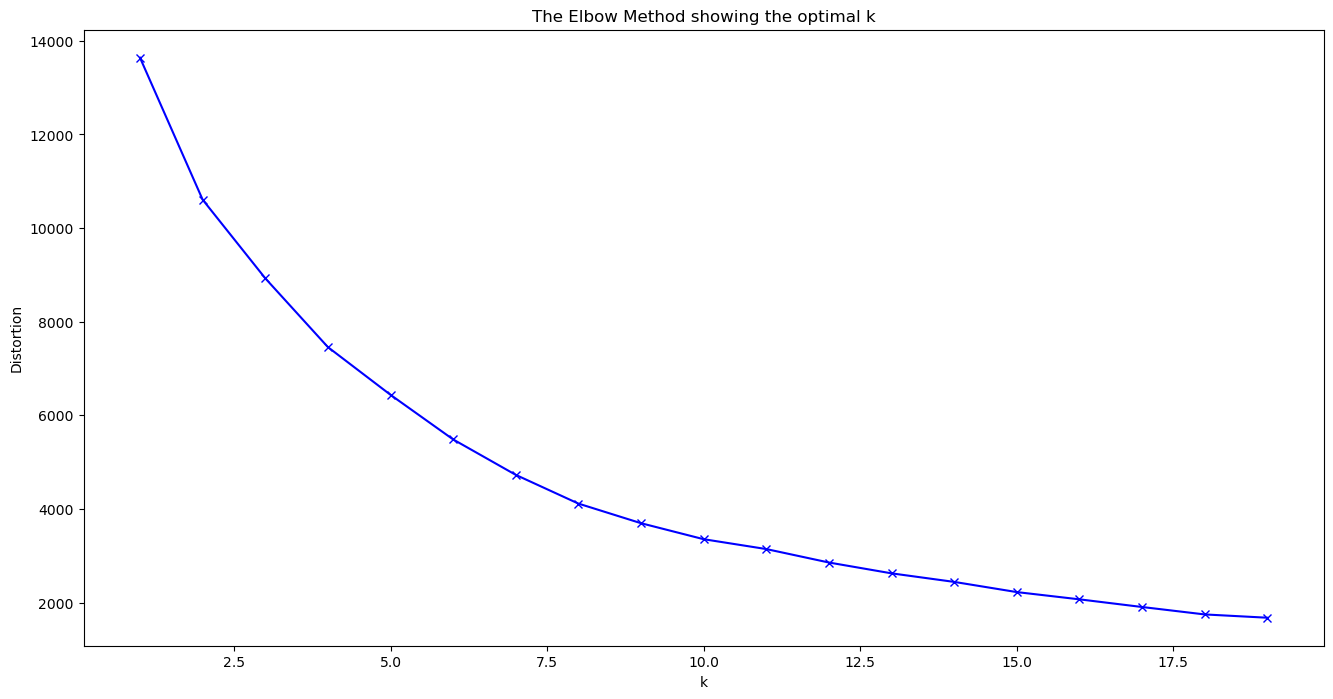

In [23]:
cluster_plays = plays.loc[:,plays.columns.str.contains('play_type_')].fillna(0)
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

distortions = []
K = range(1,20)
for k in tqdm(K, total=len(K)):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(cluster_plays)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

In [24]:
kmeanModel = KMeans(n_clusters=6)
kmeanModel.fit(cluster_plays)
plays['cluster'] = kmeanModel.predict(cluster_plays)

In [25]:

all_tokens = pd.DataFrame(token_list, columns=['index_key', 'tokens'])
token_counts = all_tokens.tokens.value_counts()

n_token_mentions = 1000 

tokens_to_featurize = token_counts[token_counts>n_token_mentions].index
feature_tokens = all_tokens[all_tokens.tokens.isin(tokens_to_featurize)]

for idx, row in tqdm(plays.iterrows(), total=plays.shape[0]):
    
    description_tokens = feature_tokens.loc[feature_tokens.index_key==idx, 'tokens'].tolist()
    description_tokens.sort()
    play_description_clean = (' '.join(list(set(description_tokens))))

    plays.loc[idx, 'play_description_clean'] = play_description_clean
    
    

plays.play_description_clean

100%|██████████| 7520/7520 [00:03<00:00, 2152.90it/s]


0       incomplete right pass deep shotgun
1          yards left pass ob deep shotgun
2          yards middle pass short shotgun
3                incomplete deep left pass
4       incomplete left pass short shotgun
                       ...                
7515                 yards short left pass
7516                yards right short pass
7517        yards right pass short shotgun
7518               shotgun short left pass
7519        yards right pass short shotgun
Name: play_description_clean, Length: 7520, dtype: object

In [26]:
for c in sorted(plays.cluster.unique()):
    cluster_words = []
    print(f"Top value counts in cluster #{c}:\n")
    descriptions = plays[plays.cluster==c].play_description_clean
    print(descriptions.value_counts())
    for description in descriptions:
        description_words = description.split(' ')
        
        for word in description_words:
            cluster_words.append(word)
            
    print(pd.Series(cluster_words).value_counts()[0:4].index)
        
    
    
    print('\n')    
    
plays.loc[plays.cluster==0, 'cluster_descripiton'] = 'deep pass'
plays.loc[plays.cluster==1, 'cluster_descripiton'] = 'short right pass'
plays.loc[plays.cluster==2, 'cluster_descripiton'] = 'non descript'
plays.loc[plays.cluster==3, 'cluster_descripiton'] = 'short middle pass'
plays.loc[plays.cluster==4, 'cluster_descripiton'] = 'short left pass'


Top value counts in cluster #0:

incomplete right pass short shotgun     511
incomplete left pass short shotgun      448
incomplete middle pass short shotgun    266
incomplete short right pass             109
incomplete short left pass               73
incomplete short middle pass             36
incomplete pass                          12
incomplete right pass                     1
Name: play_description_clean, dtype: int64
Index(['incomplete', 'pass', 'short', 'shotgun'], dtype='object')


Top value counts in cluster #1:

yards right pass short shotgun                  765
yards right pass ob short shotgun               276
yards right short pass                          194
yards right pass ob short                        90
incomplete yards right pass short shotgun        56
right short shotgun pass                         33
right short pass                                 18
incomplete yards right pass short                15
right pass ob short shotgun                       5
pas

In [27]:
plays.playDescription = plays.playDescription.str.lower()
plays.playDescription = plays.playDescription.replace('[^a-z0-9 ]', '', regex=True)

split_descriptions = plays.playDescription.str.split(' ')
split_descriptions

0       [, shotgun, tbrady, pass, incomplete, deep, ri...
1       [, shotgun, dprescott, pass, deep, left, to, a...
2       [, shotgun, dprescott, pass, short, middle, to...
3       [, dprescott, pass, incomplete, deep, left, to...
4       [, shotgun, dprescott, pass, incomplete, short...
                              ...                        
7515    [, tbridgewater, pass, short, left, to, aokwue...
7516    [, tbridgewater, pass, short, right, to, tpatr...
7517    [, shotgun, tbridgewater, pass, short, right, ...
7518    [, shotgun, theinicke, pass, short, left, to, ...
7519    [, no, huddle, shotgun, theinicke, pass, short...
Name: playDescription, Length: 7520, dtype: object

## Drop and start over with cleaner descriptions


In [28]:
plays = plays.loc[:,~plays.columns.str.contains('play_type_')]

In [29]:
stop_words.extend(['ob', 'yards', 'pass'])  # common between a lot of descriptions types and not good for differntiation
from tqdm import tqdm 
token_list = []
for i in tqdm(range(len(split_descriptions)), total=len(split_descriptions)):
    desc = split_descriptions[i]

    for token in desc:
        if token and token not in stop_words:
            token_list.append([i,token])
    
# token_list

100%|██████████| 7520/7520 [00:00<00:00, 26108.01it/s]


In [30]:

all_tokens = pd.DataFrame(token_list, columns=['index_key', 'tokens'])
token_counts = all_tokens.tokens.value_counts()

n_token_mentions = 1000 

tokens_to_featurize = token_counts[token_counts>n_token_mentions].index
feature_tokens = all_tokens[all_tokens.tokens.isin(tokens_to_featurize)]

for idx, row in tqdm(feature_tokens.iterrows(), total=feature_tokens.shape[0]):
    key = row.index_key
    token = row.tokens
    
    plays.loc[plays.index==key, f'play_type_{token}'] = 1

plays.loc[:,plays.columns.str.contains('play_type_')] = plays.loc[:,plays.columns.str.contains('play_type_')].fillna(0)
plays

  0%|          | 0/22317 [00:00<?, ?it/s]/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/3232745734.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plays.loc[plays.index==key, f'play_type_{token}'] = 1
/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/3232745734.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plays.loc[plays.index==key, f'play_type_{token}'] = 1
/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/3232745734.py:13: SettingWithCopyWarning: 


,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,defensiveTeam_next_play,preSnapVisitorScore_next_play,possessionTeam_next_play,preSnapHomeScore_next_play,is_turnover,visitors_scored,home_team_scored,play_start_times,series_id,series_successful,cluster,play_description_clean,cluster_descripiton,play_type_shotgun,play_type_incomplete,play_type_deep,play_type_right,play_type_left,play_type_short,play_type_middle
0,2021090900,97,shotgun tbrady pass incomplete deep right to ...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,TB,0.0,DAL,0.0,1,0,0,00:26:31,1.0,0.0,2,incomplete right pass deep shotgun,non descript,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,2021090900,137,shotgun dprescott pass deep left to acooper p...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:28:09,2.0,0.0,2,yards left pass ob deep shotgun,non descript,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,2021090900,187,shotgun dprescott pass short middle to dschul...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:29:15,2.0,0.0,4,yards middle pass short shotgun,short left pass,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3,2021090900,282,dprescott pass incomplete deep left to clamb,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:31:51,2.0,0.0,2,incomplete deep left pass,non descript,0.0,1.0,1.0,0.0,1.0,0.0,0.0
4,2021090900,349,shotgun dprescott pass incomplete short left ...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,DAL,0.0,TB,0.0,1,0,0,00:34:05,2.0,0.0,0,incomplete left pass short shotgun,deep pass,1.0,1.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7515,2021103110,1459,tbridgewater pass short left to aokwuegbunam ...,2,1,10,DEN,WAS,DEN,47,02:26,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,63.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:26:09,1929.0,1.0,3,yards short left pass,short middle pass,0.0,0.0,0.0,0.0,1.0,1.0,0.0
7516,2021103110,1500,tbridgewater pass short right to tpatrick to ...,2,1,10,DEN,WAS,WAS,34,02:00,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,44.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:29:39,1929.0,1.0,1,yards right short pass,short right pass,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7517,2021103110,1524,shotgun tbridgewater pass short right to mgor...,2,1,10,DEN,WAS,WAS,15,01:18,3,3,C,NaN,15,15,NaN,NaN,NaN,NaN,NaN,NaN,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Quarters,Zone,DEN,3.0,WAS,10.0,1,0,1,21:30:22,1929.0,1.0,1,yards right pass short shotgun,short right pass,1.0,0.0,0.0,1.0,0.0,1.0,0.0
7518,2021103110,1580,shotgun theinicke pass short left to jmckissi...,2,1,10,WAS,DEN,WAS,25,01:11,10,3,C,NaN,1,1,NaN,NaN,NaN,NaN,NaN,NaN,35.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"2 DL, 3 LB, 6 DB",TRADITIONAL,0,Cover-6,Zone,DEN,3.0,WAS,10.0,0,0,0,21:34:57,1930.0,0.0,3,shotgun short left pass,short middle pass,1.0,0.0,0.0,0.0,1.0,1.0,0.0


100%|██████████| 19/19 [00:01<00:00, 12.42it/s]


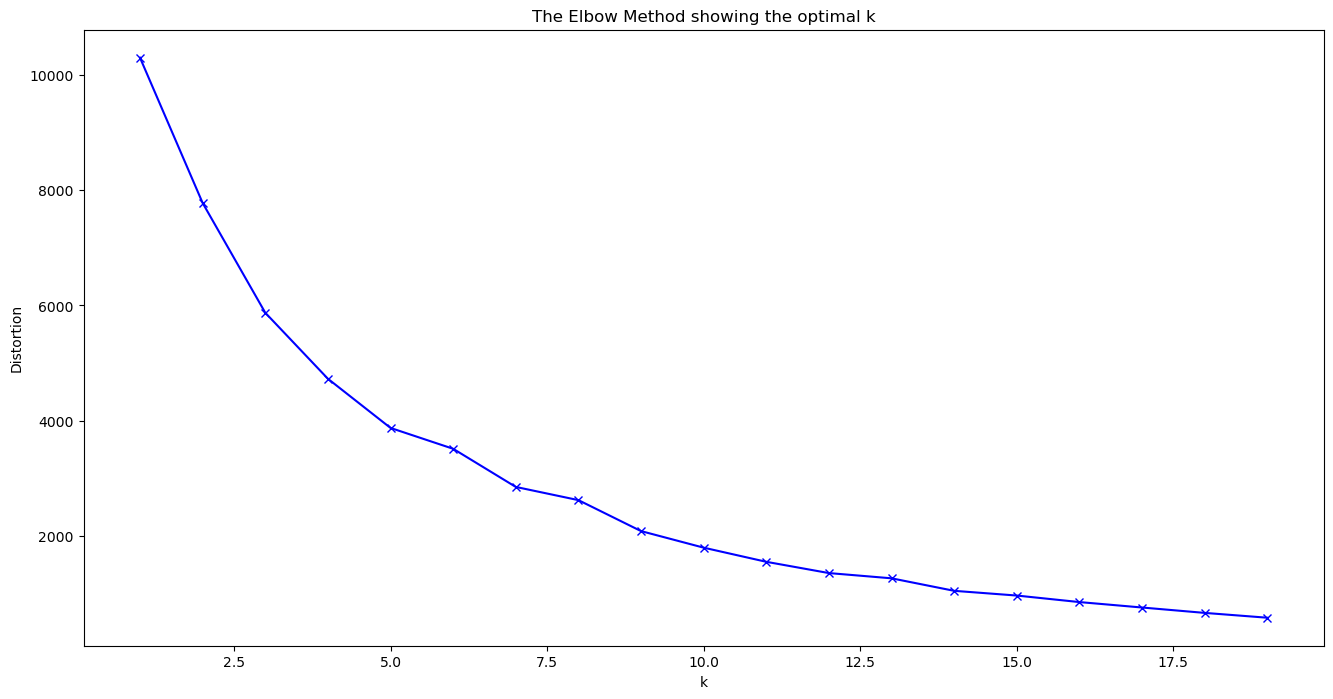

In [31]:
cluster_plays = plays.loc[:,plays.columns.str.contains('play_type_')].fillna(0)
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.cluster import KMeans

distortions = []
K = range(1,20)
for k in tqdm(K, total=len(K)):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(cluster_plays)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()    

In [32]:
kmeanModel = KMeans(n_clusters=4)
kmeanModel.fit(cluster_plays)
plays['cluster'] = kmeanModel.predict(cluster_plays)

/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/1514008227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plays['cluster'] = kmeanModel.predict(cluster_plays)


In [33]:

all_tokens = pd.DataFrame(token_list, columns=['index_key', 'tokens'])
token_counts = all_tokens.tokens.value_counts()

n_token_mentions = 1000 

tokens_to_featurize = token_counts[token_counts>n_token_mentions].index
feature_tokens = all_tokens[all_tokens.tokens.isin(tokens_to_featurize)]

for idx, row in tqdm(plays.iterrows(), total=plays.shape[0]):
    
    description_tokens = feature_tokens.loc[feature_tokens.index_key==idx, 'tokens'].tolist()
    description_tokens.sort()
    play_description_clean = (' '.join(list(set(description_tokens))))
    plays.loc[idx, 'play_description_clean'] = play_description_clean
        
plays.play_description_clean

100%|██████████| 7520/7520 [00:02<00:00, 2801.82it/s]


0       incomplete shotgun deep right
1                   shotgun deep left
2                shotgun short middle
3                incomplete deep left
4       incomplete shotgun short left
                    ...              
7515                       short left
7516                      right short
7517              right short shotgun
7518               shotgun short left
7519              right short shotgun
Name: play_description_clean, Length: 7520, dtype: object

In [34]:
for c in sorted(plays.cluster.unique()):
    cluster_words = []
    print(f"Top value counts in cluster #{c}:\n")
    descriptions = plays[plays.cluster==c].play_description_clean
    print(descriptions.value_counts())
    for description in descriptions:
        description_words = description.split(' ')
        
        for word in description_words:
            cluster_words.append(word)
            
    cluster_descripiton = ' '.join(list(pd.Series(cluster_words).value_counts()[0:3].index))
        
    plays.loc[plays.cluster==c, 'cluster_descripiton'] = cluster_descripiton
    
    print('\n')    
    
plays.cluster_descripiton.value_counts()

Top value counts in cluster #0:

shotgun                           396
incomplete shotgun deep left      279
incomplete shotgun deep right     275
right deep shotgun                198
shotgun deep left                 183
shotgun deep middle               136
                                  103
incomplete shotgun deep middle     94
deep left                          70
incomplete deep left               67
incomplete deep right              66
right deep                         39
deep middle                        37
incomplete deep middle             22
incomplete                         13
Name: play_description_clean, dtype: int64


Top value counts in cluster #1:

right short shotgun               1079
incomplete shotgun short right     568
right short                        305
right shotgun                      127
incomplete short right             124
right                               38
incomplete right                     1
right short middle                   1
Name: p

right short shotgun        2243
shotgun deep incomplete    1978
left short shotgun         1943
middle short shotgun       1356
Name: cluster_descripiton, dtype: int64

## Checking which Clusters get the most yardage gain when a pass is completed

right short shotgun        1362
left short shotgun         1236
middle short shotgun        868
shotgun deep incomplete     594
Name: cluster_descripiton, dtype: int64


<AxesSubplot:xlabel='prePenaltyPlayResult', ylabel='cluster_descripiton'>

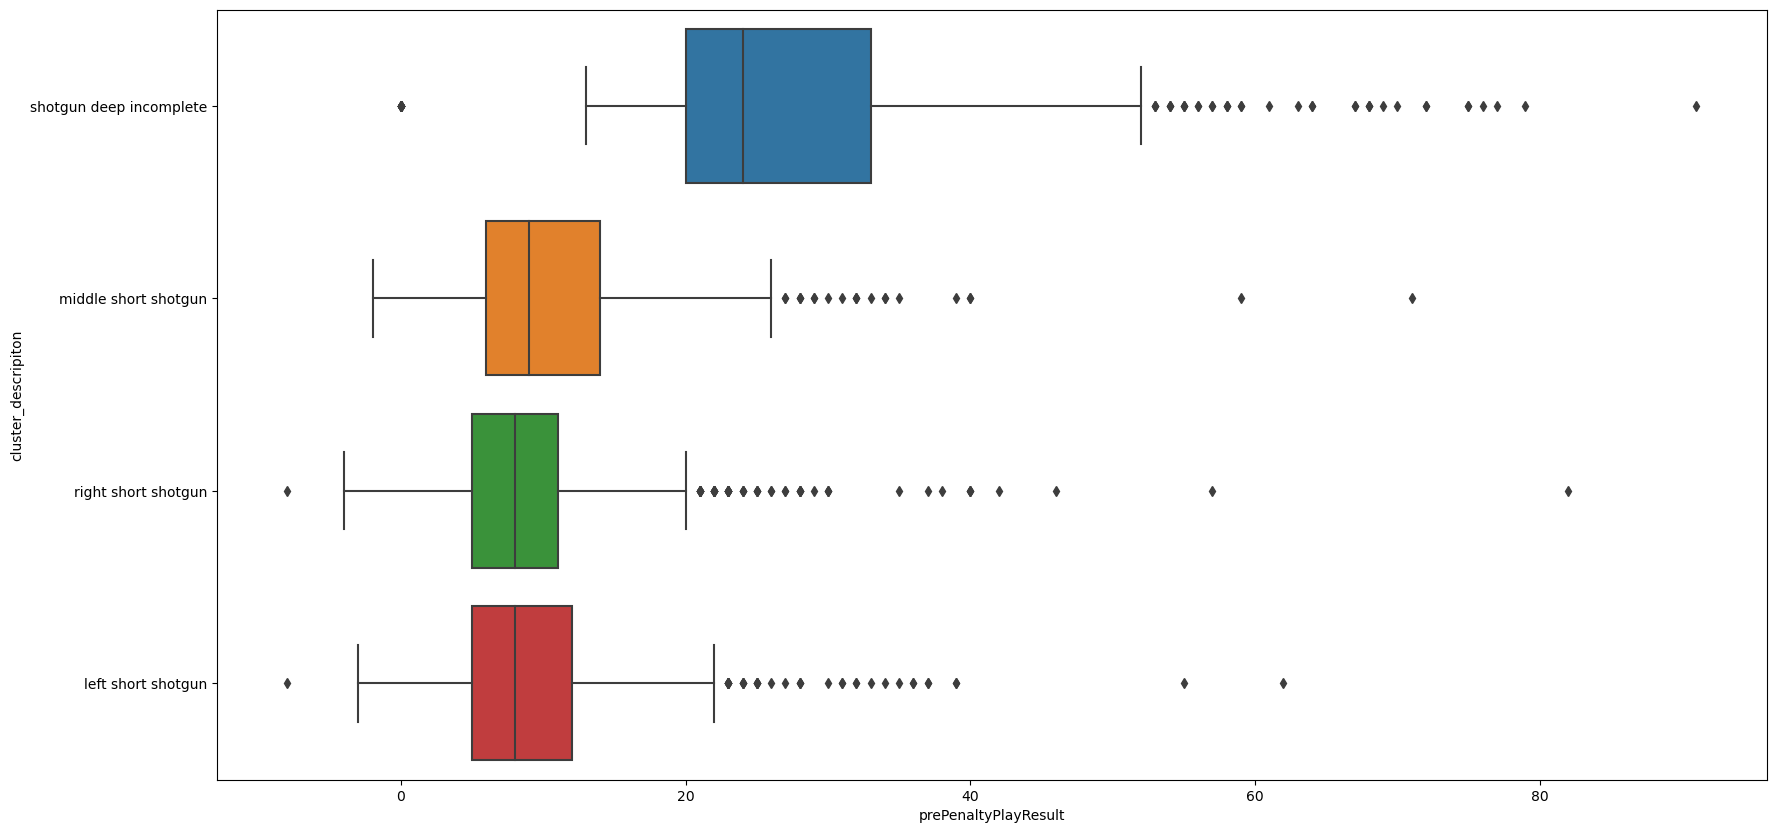

In [35]:
data= plays[plays.passResult=='C']

print(data.cluster_descripiton.value_counts())


plt.figure(figsize=(20,10))
sns.boxplot(x=plays[plays.passResult=='C'].prePenaltyPlayResult, y=plays[plays.passResult=='C'].cluster_descripiton)


## Formatting game clock to numeric


In [36]:

game_clock_split = plays.gameClock.str.split(':')

for i in tqdm(range(len(game_clock_split)), total=len(game_clock_split)):
    n_mins_remaining = int(game_clock_split[i][0])
    
    n_secs_remaining = n_mins_remaining*60
        
    n_secs_remaining += int(game_clock_split[i][1])

    plays.loc[i,'game_clock_seconds'] = n_secs_remaining


  0%|          | 0/7520 [00:00<?, ?it/s]/var/folders/s7/3dcc3pkd0kb7tgrb1sc5zlzh0000gn/T/ipykernel_4355/2579936633.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plays.loc[i,'game_clock_seconds'] = n_secs_remaining
100%|██████████| 7520/7520 [00:00<00:00, 11353.92it/s]


## Create date features

In [37]:
games_df = create_date_features(games_df)


In [38]:
plays = plays.merge(games_df, on='gameId')

In [39]:
drop_na_cols = ['absoluteYardlineNumber', 'offenseFormation', 'personnelO', 'defendersInBox', 'personnelD']

plays = plays.dropna(subset=drop_na_cols).reset_index(drop=True)
plays

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,preSnapVisitorScore,passResult,penaltyYards,prePenaltyPlayResult,playResult,foulName1,foulNFLId1,foulName2,foulNFLId2,foulName3,foulNFLId3,absoluteYardlineNumber,offenseFormation,personnelO,defendersInBox,personnelD,dropBackType,pff_playAction,pff_passCoverage,pff_passCoverageType,defensiveTeam_next_play,preSnapVisitorScore_next_play,possessionTeam_next_play,preSnapHomeScore_next_play,is_turnover,visitors_scored,home_team_scored,play_start_times,series_id,series_successful,cluster,play_description_clean,cluster_descripiton,play_type_shotgun,play_type_incomplete,play_type_deep,play_type_right,play_type_left,play_type_short,play_type_middle,game_clock_seconds,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,gameDate_month,gameDate_day,gameDate_year
0,2021090900,97,shotgun tbrady pass incomplete deep right to ...,1,3,2,TB,DAL,TB,33,13:33,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,43.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-1,Man,TB,0.0,DAL,0.0,1,0,0,00:26:31,1.0,0.0,0,incomplete shotgun deep right,shotgun deep incomplete,1.0,1.0,1.0,1.0,0.0,0.0,0.0,813.0,2021,1,2021-09-09,20:20:00,TB,DAL,9,3,2021
1,2021090900,137,shotgun dprescott pass deep left to acooper p...,1,1,10,DAL,TB,DAL,2,13:18,0,0,C,NaN,28,28,NaN,NaN,NaN,NaN,NaN,NaN,108.0,EMPTY,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 4 LB, 3 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:28:09,2.0,0.0,0,shotgun deep left,shotgun deep incomplete,1.0,0.0,1.0,0.0,1.0,0.0,0.0,798.0,2021,1,2021-09-09,20:20:00,TB,DAL,9,3,2021
2,2021090900,187,shotgun dprescott pass short middle to dschul...,1,2,6,DAL,TB,DAL,34,12:23,0,0,C,NaN,5,5,NaN,NaN,NaN,NaN,NaN,NaN,76.0,SHOTGUN,"0 RB, 2 TE, 3 WR",6.0,"3 DL, 3 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:29:15,2.0,0.0,3,shotgun short middle,middle short shotgun,1.0,0.0,0.0,0.0,0.0,1.0,1.0,743.0,2021,1,2021-09-09,20:20:00,TB,DAL,9,3,2021
3,2021090900,282,dprescott pass incomplete deep left to clamb,1,1,10,DAL,TB,TB,39,09:56,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,49.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",6.0,"4 DL, 3 LB, 4 DB",TRADITIONAL,1,Cover-3,Zone,TB,0.0,DAL,0.0,0,0,0,00:31:51,2.0,0.0,0,incomplete deep left,shotgun deep incomplete,0.0,1.0,1.0,0.0,1.0,0.0,0.0,596.0,2021,1,2021-09-09,20:20:00,TB,DAL,9,3,2021
4,2021090900,349,shotgun dprescott pass incomplete short left ...,1,3,15,DAL,TB,TB,44,09:46,0,0,I,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,54.0,SHOTGUN,"1 RB, 1 TE, 3 WR",7.0,"3 DL, 4 LB, 4 DB",TRADITIONAL,0,Cover-3,Zone,DAL,0.0,TB,0.0,1,0,0,00:34:05,2.0,0.0,2,incomplete shotgun short left,left short shotgun,1.0,1.0,0.0,0.0,1.0,1.0,0.0,586.0,2021,1,2021-09-09,20:20:00,TB,DAL,9,3,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7508,2021103110,1459,tbridgewater pass short left to aokwuegbunam ...,2,1,10,DEN,WAS,DEN,47,02:26,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,63.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",7.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,1,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:26:09,1929.0,1.0,2,short left,left short shotgun,0.0,0.0,0.0,0.0,1.0,1.0,0.0,146.0,2021,8,2021-10-31,16:25:00,DEN,WAS,10,6,2021
7509,2021103110,1500,tbridgewater pass short right to tpatrick to ...,2,1,10,DEN,WAS,WAS,34,02:00,3,3,C,NaN,19,19,NaN,NaN,NaN,NaN,NaN,NaN,44.0,SINGLEBACK,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Cover-3,Zone,WAS,3.0,DEN,3.0,0,0,0,21:29:39,1929.0,1.0,1,right short,right short shotgun,0.0,0.0,0.0,1.0,0.0,1.0,0.0,120.0,2021,8,2021-10-31,16:25:00,DEN,WAS,10,6,2021
7510,2021103110,1524,shotgun tbridgewater pass short right to mgor...,2,1,10,DEN,WAS,WAS,15,01:18,3,3,C,NaN,15,15,NaN,NaN,NaN,NaN,NaN,NaN,25.0,SHOTGUN,"1 RB, 1 TE, 3 WR",6.0,"4 DL, 2 LB, 5 DB",TRADITIONAL,0,Q

## Personnel positional counts (defense)

In [40]:
split_defenders = plays.personnelD.str.split(',')

for i in tqdm(range(len(split_defenders)), total=len(split_defenders)):
    defenders = split_defenders[i]
    for defender in defenders:
        values = defender.split(' ')
        values = [v for v in values if v]
        number_value = values[0]        
        string_value = values[1]
        plays.loc[i, f'{string_value}_count_defense'] = int(number_value)
        
    

100%|██████████| 7513/7513 [00:01<00:00, 4206.79it/s]


## Personnel positional counts (offense)

In [41]:
split_offenders = plays.personnelO.str.split(',')

for i in tqdm(range(len(split_offenders)), total=len(split_offenders)):
    offenders = split_offenders[i]
    for offender in offenders:
        
        values = offender.split(' ')
        values = [v for v in values if v]

        number_value = values[0]
        string_value = values[1]
        
        plays.loc[i, f'{string_value}_count_offense'] = int(number_value)
    



100%|██████████| 7513/7513 [00:01<00:00, 4181.39it/s]


In [42]:
plays.loc[:,plays.columns.str.contains('_offense|_defense')].isna().sum()

DL_count_defense       0
LB_count_defense       0
DB_count_defense       0
RB_count_offense       0
TE_count_offense       0
WR_count_offense       0
OL_count_offense    7435
QB_count_offense    7481
LB_count_offense    7512
dtype: int64

In [43]:
plays.drop(['OL_count_offense', 'LB_count_offense', 'QB_count_offense'], axis=1, inplace=True)

## Where yardlineSide is NA, the ball is on line 50

In [44]:

print(plays[plays.yardlineSide.isna()]['yardlineNumber'].describe())

# backfill yardlineSide at the possessionTeam 
plays.loc[plays.yardlineSide.isna(), 'yardlineSide'] = plays[plays.yardlineSide.isna()]['possessionTeam']



count    115.0
mean      50.0
std        0.0
min       50.0
25%       50.0
50%       50.0
75%       50.0
max       50.0
Name: yardlineNumber, dtype: float64


In [45]:
plays['home_team_possesses_ball'] = plays.possessionTeam == plays.homeTeamAbbr
plays['visitors_possess_ball'] = plays.possessionTeam == plays.visitorTeamAbbr
plays['home_team_possesses_ball'] = plays['home_team_possesses_ball'].astype('int8')
plays['visitors_possess_ball'] = plays['visitors_possess_ball'].astype('int8')
print(f"% of time visitors possess the ball: {round(sum(plays['visitors_possess_ball'])/plays.shape[0]*100,2)}%")
print(f"% of time home team posses the ball: {round(sum(plays['home_team_possesses_ball'])/plays.shape[0]*100,2)}%")


% of time visitors possess the ball: 48.82%
% of time home team posses the ball: 51.18%


In [46]:

conditions = [plays.possessionTeam == plays.homeTeamAbbr, plays.possessionTeam == plays.visitorTeamAbbr]
values = [1, 0]


plays['possession_team_is_home_team'] = np.select(conditions, values)
plays['possession_team_is_home_team']

0       1
1       0
2       0
3       0
4       0
       ..
7508    1
7509    1
7510    1
7511    0
7512    0
Name: possession_team_is_home_team, Length: 7513, dtype: int64

In [47]:
import numpy as np

conditions = [
    (plays.possessionTeam == plays.homeTeamAbbr) & (plays.home_team_scored == 1)
    ,(plays.possessionTeam == plays.visitorTeamAbbr) & (plays.visitors_scored == 1)
    ,(plays.home_team_scored==0) & (plays.visitors_scored==0)
]

values = [1, 1, 0]

plays['possession_team_scored'] = np.select(conditions, values)
plays['possession_team_scored']

0       0
1       0
2       0
3       0
4       0
       ..
7508    0
7509    0
7510    1
7511    0
7512    0
Name: possession_team_scored, Length: 7513, dtype: int64

## Convert playDirection string to binary variable

In [48]:
plays = plays.merge(weeks_df[['gameId', 'playId', 'playDirection']].drop_duplicates(), on=['gameId', 'playId'])

conditions = [plays.playDirection == 'right', plays.playDirection == 'left']
values = [1, 0]


plays['play_direction_is_right'] = np.select(conditions, values)
plays['play_direction_is_right']

0       1
1       0
2       0
3       0
4       0
       ..
7508    0
7509    0
7510    0
7511    1
7512    1
Name: play_direction_is_right, Length: 7513, dtype: int64

## Add total number of plays per game

In [49]:
plays = pd.merge(plays, pd.Series(plays.groupby('gameId')['playId'].count(), name='total_plays'), on='gameId')

## Save df to be used for model training

In [50]:
plays.to_csv('/Users/ciannudi-muldoon/Projects/nfl_data_bowl/data/RL_test_data.csv')